<a href="https://colab.research.google.com/github/roshantac/EVA4/blob/master/Step7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [3]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


# Dataloader Arguments & Test/Train Dataloaders


In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# The model
Let's start with the model we first saw

In [0]:
import torch.nn.functional as F
dropout_value = 0.1
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(10),
            nn.Dropout(dropout_value)
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=20, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(20),
            nn.Dropout(dropout_value)
        ) # output_size = 24

        # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 24
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=20, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(20),
            nn.Dropout(dropout_value)
        ) # output_size = 10
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 8
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(10),
            nn.Dropout(dropout_value)
        ) # output_size = 6
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 6
        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) # output_size = 1

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # nn.BatchNorm2d(10),
            # nn.ReLU(),
            # nn.Dropout(dropout_value)
        ) 


        self.dropout = nn.Dropout(dropout_value)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.gap(x)        
        x = self.convblock8(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)



# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [6]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
              ReLU-2           [-1, 10, 26, 26]               0
       BatchNorm2d-3           [-1, 10, 26, 26]              20
           Dropout-4           [-1, 10, 26, 26]               0
            Conv2d-5           [-1, 20, 24, 24]           1,800
              ReLU-6           [-1, 20, 24, 24]               0
       BatchNorm2d-7           [-1, 20, 24, 24]              40
           Dropout-8           [-1, 20, 24, 24]               0
            Conv2d-9           [-1, 10, 24, 24]             200
        MaxPool2d-10           [-1, 10, 12, 12]               0
           Conv2d-11           [-1, 20, 10, 10]           1,800
             ReLU-12           [-1, 20, 10, 10]               0
      BatchNorm2d-13           [-1, 20, 10, 10]              40
          Dropout-14           [-1

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch, is_L1_loss = False):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  train_acc = []
  train_losses = []
   
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    if(is_L1_loss == True):
      l1_crit = nn.L1Loss(size_average = False)
      reg_loss = 0
      for param in model.parameters():
        zero_vector = torch.rand_like(param)*0
        reg_loss +=l1_crit(param,zero_vector)
      factor = 0.0005
      loss += factor * reg_loss
    

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
  train_losses.append(loss)
  train_acc.append(100*correct/processed)
  return train_losses, train_acc

def test(model, device, test_loader):
    figsize=(15,10)
    model.eval()
    test_loss = 0
    correct = 0
    test_acc = []
    test_losses = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))
    return test_losses, test_acc

In [0]:
def runmodel(Epochs, l1 = False,l2 = 0):
  from torch.optim.lr_scheduler import StepLR
  model =  Net().to(device)
  optimizer = optim.SGD(model.parameters(), lr = 0.01, momentum = 0.95,weight_decay = l2 ) # 
  scheduler = StepLR(optimizer, step_size = 6, gamma = 0.1)
  trainLoss = []
  trainAccu = []
  testLoss = []
  testAccu =[]

  EPOCHS = Epochs
  for epoch in range(EPOCHS):
      print("EPOCH:", epoch)
      trainLosst, trainAccut = train(model, device, train_loader, optimizer, epoch, is_L1_loss = l1) 
      trainLoss.append(trainLosst) 
      trainAccu.append(trainAccut)
      testLosst, testAccut = test(model, device, test_loader)
      testLoss.append(testLosst)
      testAccu.append(testAccut)
      scheduler.step()
  return trainLoss, trainAccu, testLoss, testAccu


# Let's Train and test our model

This time let's add a scheduler for out LR. 

In [9]:
trn_ls1,trn_ac1,tst_ls1,tst_ac1 = runmodel(40,l1 = False, l2 = 0) # Normal
trn_ls2,trn_ac2,tst_ls2,tst_ac2 = runmodel(40, l1 = False, l2 = 0.01) # L2
trn_ls3,trn_ac3,tst_ls3,tst_ac3 = runmodel(40, l1 = True, l2 = 0.01) # L1
trn_ls4,trn_ac4,tst_ls4,tst_ac4 = runmodel(40, l1 = True, l2 = 0.01) # L1, L2

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.06816131621599197 Batch_id=468 Accuracy=84.23: 100%|██████████| 469/469 [00:13<00:00, 34.90it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0855, Accuracy: 9743/10000 (97.43%)

EPOCH: 1


Loss=0.1327473372220993 Batch_id=468 Accuracy=97.28: 100%|██████████| 469/469 [00:12<00:00, 37.98it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0417, Accuracy: 9870/10000 (98.70%)

EPOCH: 2


Loss=0.13467414677143097 Batch_id=468 Accuracy=98.03: 100%|██████████| 469/469 [00:12<00:00, 38.44it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0477, Accuracy: 9846/10000 (98.46%)

EPOCH: 3


Loss=0.04072925075888634 Batch_id=468 Accuracy=98.30: 100%|██████████| 469/469 [00:12<00:00, 37.80it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0293, Accuracy: 9914/10000 (99.14%)

EPOCH: 4


Loss=0.01610575057566166 Batch_id=468 Accuracy=98.42: 100%|██████████| 469/469 [00:13<00:00, 35.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0314, Accuracy: 9910/10000 (99.10%)

EPOCH: 5


Loss=0.09940483421087265 Batch_id=468 Accuracy=98.59: 100%|██████████| 469/469 [00:12<00:00, 37.43it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0284, Accuracy: 9919/10000 (99.19%)

EPOCH: 6


Loss=0.07829359918832779 Batch_id=468 Accuracy=98.79: 100%|██████████| 469/469 [00:12<00:00, 37.86it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0237, Accuracy: 9929/10000 (99.29%)

EPOCH: 7


Loss=0.022690603509545326 Batch_id=468 Accuracy=98.92: 100%|██████████| 469/469 [00:12<00:00, 38.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0235, Accuracy: 9935/10000 (99.35%)

EPOCH: 8


Loss=0.04106497764587402 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:12<00:00, 36.59it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0234, Accuracy: 9931/10000 (99.31%)

EPOCH: 9


Loss=0.08144327998161316 Batch_id=468 Accuracy=98.95: 100%|██████████| 469/469 [00:12<00:00, 38.31it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0230, Accuracy: 9931/10000 (99.31%)

EPOCH: 10


Loss=0.06544610857963562 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:12<00:00, 38.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0221, Accuracy: 9933/10000 (99.33%)

EPOCH: 11


Loss=0.04722380265593529 Batch_id=468 Accuracy=98.98: 100%|██████████| 469/469 [00:12<00:00, 38.48it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0220, Accuracy: 9935/10000 (99.35%)

EPOCH: 12


Loss=0.06333868950605392 Batch_id=468 Accuracy=99.03: 100%|██████████| 469/469 [00:12<00:00, 37.51it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0218, Accuracy: 9934/10000 (99.34%)

EPOCH: 13


Loss=0.04992828890681267 Batch_id=468 Accuracy=99.04: 100%|██████████| 469/469 [00:12<00:00, 36.80it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0226, Accuracy: 9931/10000 (99.31%)

EPOCH: 14


Loss=0.00504004443064332 Batch_id=468 Accuracy=99.05: 100%|██████████| 469/469 [00:12<00:00, 37.72it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0228, Accuracy: 9930/10000 (99.30%)

EPOCH: 15


Loss=0.009958595037460327 Batch_id=468 Accuracy=99.01: 100%|██████████| 469/469 [00:12<00:00, 39.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0226, Accuracy: 9931/10000 (99.31%)

EPOCH: 16


Loss=0.031915467232465744 Batch_id=468 Accuracy=99.06: 100%|██████████| 469/469 [00:12<00:00, 37.71it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0219, Accuracy: 9930/10000 (99.30%)

EPOCH: 17


Loss=0.09333115071058273 Batch_id=468 Accuracy=99.06: 100%|██████████| 469/469 [00:12<00:00, 44.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0223, Accuracy: 9932/10000 (99.32%)

EPOCH: 18


Loss=0.008852074854075909 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:12<00:00, 38.48it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0223, Accuracy: 9933/10000 (99.33%)

EPOCH: 19


Loss=0.01050521433353424 Batch_id=468 Accuracy=99.06: 100%|██████████| 469/469 [00:12<00:00, 37.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0224, Accuracy: 9933/10000 (99.33%)

EPOCH: 20


Loss=0.009977072477340698 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:12<00:00, 38.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0223, Accuracy: 9930/10000 (99.30%)

EPOCH: 21


Loss=0.04602670297026634 Batch_id=468 Accuracy=99.05: 100%|██████████| 469/469 [00:12<00:00, 36.28it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0218, Accuracy: 9932/10000 (99.32%)

EPOCH: 22


Loss=0.03625058755278587 Batch_id=468 Accuracy=99.01: 100%|██████████| 469/469 [00:12<00:00, 37.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0226, Accuracy: 9932/10000 (99.32%)

EPOCH: 23


Loss=0.01996348798274994 Batch_id=468 Accuracy=98.99: 100%|██████████| 469/469 [00:12<00:00, 37.44it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0221, Accuracy: 9933/10000 (99.33%)

EPOCH: 24


Loss=0.020093193277716637 Batch_id=468 Accuracy=99.03: 100%|██████████| 469/469 [00:12<00:00, 38.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0211, Accuracy: 9935/10000 (99.35%)

EPOCH: 25


Loss=0.03342527151107788 Batch_id=468 Accuracy=99.06: 100%|██████████| 469/469 [00:12<00:00, 36.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0221, Accuracy: 9933/10000 (99.33%)

EPOCH: 26


Loss=0.04894369840621948 Batch_id=468 Accuracy=99.04: 100%|██████████| 469/469 [00:13<00:00, 35.86it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0218, Accuracy: 9935/10000 (99.35%)

EPOCH: 27


Loss=0.045629099011421204 Batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:12<00:00, 36.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0219, Accuracy: 9931/10000 (99.31%)

EPOCH: 28


Loss=0.06519528478384018 Batch_id=468 Accuracy=99.06: 100%|██████████| 469/469 [00:12<00:00, 37.35it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0217, Accuracy: 9929/10000 (99.29%)

EPOCH: 29


Loss=0.012285108678042889 Batch_id=468 Accuracy=99.02: 100%|██████████| 469/469 [00:12<00:00, 36.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0217, Accuracy: 9934/10000 (99.34%)

EPOCH: 30


Loss=0.017278367653489113 Batch_id=468 Accuracy=99.05: 100%|██████████| 469/469 [00:12<00:00, 36.28it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0219, Accuracy: 9932/10000 (99.32%)

EPOCH: 31


Loss=0.03861205652356148 Batch_id=468 Accuracy=99.04: 100%|██████████| 469/469 [00:12<00:00, 42.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0225, Accuracy: 9932/10000 (99.32%)

EPOCH: 32


Loss=0.030241036787629128 Batch_id=468 Accuracy=99.05: 100%|██████████| 469/469 [00:12<00:00, 37.58it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0219, Accuracy: 9934/10000 (99.34%)

EPOCH: 33


Loss=0.03743160143494606 Batch_id=468 Accuracy=99.03: 100%|██████████| 469/469 [00:12<00:00, 42.20it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0226, Accuracy: 9930/10000 (99.30%)

EPOCH: 34


Loss=0.059661492705345154 Batch_id=468 Accuracy=99.02: 100%|██████████| 469/469 [00:13<00:00, 34.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0216, Accuracy: 9935/10000 (99.35%)

EPOCH: 35


Loss=0.07508187741041183 Batch_id=468 Accuracy=99.07: 100%|██████████| 469/469 [00:12<00:00, 36.78it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0223, Accuracy: 9933/10000 (99.33%)

EPOCH: 36


Loss=0.006129225250333548 Batch_id=468 Accuracy=99.06: 100%|██████████| 469/469 [00:13<00:00, 35.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0218, Accuracy: 9930/10000 (99.30%)

EPOCH: 37


Loss=0.10628170520067215 Batch_id=468 Accuracy=99.09: 100%|██████████| 469/469 [00:12<00:00, 36.44it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0219, Accuracy: 9934/10000 (99.34%)

EPOCH: 38


Loss=0.04486672207713127 Batch_id=468 Accuracy=99.03: 100%|██████████| 469/469 [00:13<00:00, 34.62it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0220, Accuracy: 9932/10000 (99.32%)

EPOCH: 39


Loss=0.02698102593421936 Batch_id=468 Accuracy=99.02: 100%|██████████| 469/469 [00:13<00:00, 35.71it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0220, Accuracy: 9933/10000 (99.33%)

EPOCH: 0


Loss=0.13521338999271393 Batch_id=468 Accuracy=86.35: 100%|██████████| 469/469 [00:13<00:00, 42.19it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1744, Accuracy: 9653/10000 (96.53%)

EPOCH: 1


Loss=0.13687120378017426 Batch_id=468 Accuracy=96.95: 100%|██████████| 469/469 [00:13<00:00, 35.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1164, Accuracy: 9716/10000 (97.16%)

EPOCH: 2


Loss=0.10975301265716553 Batch_id=468 Accuracy=97.13: 100%|██████████| 469/469 [00:13<00:00, 34.10it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0861, Accuracy: 9832/10000 (98.32%)

EPOCH: 3


Loss=0.0834493339061737 Batch_id=468 Accuracy=97.48: 100%|██████████| 469/469 [00:13<00:00, 35.62it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0983, Accuracy: 9775/10000 (97.75%)

EPOCH: 4


Loss=0.11441812664270401 Batch_id=468 Accuracy=97.60: 100%|██████████| 469/469 [00:13<00:00, 34.21it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0917, Accuracy: 9806/10000 (98.06%)

EPOCH: 5


Loss=0.16292335093021393 Batch_id=468 Accuracy=97.57: 100%|██████████| 469/469 [00:13<00:00, 35.14it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1178, Accuracy: 9770/10000 (97.70%)

EPOCH: 6


Loss=0.06328115612268448 Batch_id=468 Accuracy=98.50: 100%|██████████| 469/469 [00:13<00:00, 33.80it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0496, Accuracy: 9915/10000 (99.15%)

EPOCH: 7


Loss=0.06485338509082794 Batch_id=468 Accuracy=98.67: 100%|██████████| 469/469 [00:13<00:00, 34.86it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0497, Accuracy: 9917/10000 (99.17%)

EPOCH: 8


Loss=0.036127474159002304 Batch_id=468 Accuracy=98.72: 100%|██████████| 469/469 [00:13<00:00, 39.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0534, Accuracy: 9914/10000 (99.14%)

EPOCH: 9


Loss=0.06481895595788956 Batch_id=468 Accuracy=98.71: 100%|██████████| 469/469 [00:13<00:00, 35.14it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0513, Accuracy: 9918/10000 (99.18%)

EPOCH: 10


Loss=0.10863258689641953 Batch_id=468 Accuracy=98.66: 100%|██████████| 469/469 [00:14<00:00, 33.40it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0516, Accuracy: 9920/10000 (99.20%)

EPOCH: 11


Loss=0.11331678181886673 Batch_id=468 Accuracy=98.71: 100%|██████████| 469/469 [00:13<00:00, 35.29it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0530, Accuracy: 9905/10000 (99.05%)

EPOCH: 12


Loss=0.09060303121805191 Batch_id=468 Accuracy=98.88: 100%|██████████| 469/469 [00:13<00:00, 34.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0452, Accuracy: 9930/10000 (99.30%)

EPOCH: 13


Loss=0.06798955053091049 Batch_id=468 Accuracy=98.95: 100%|██████████| 469/469 [00:13<00:00, 35.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0430, Accuracy: 9936/10000 (99.36%)

EPOCH: 14


Loss=0.04647621884942055 Batch_id=468 Accuracy=98.90: 100%|██████████| 469/469 [00:13<00:00, 33.62it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0445, Accuracy: 9926/10000 (99.26%)

EPOCH: 15


Loss=0.07715123891830444 Batch_id=468 Accuracy=98.95: 100%|██████████| 469/469 [00:13<00:00, 39.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0437, Accuracy: 9928/10000 (99.28%)

EPOCH: 16


Loss=0.12993140518665314 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:13<00:00, 35.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0431, Accuracy: 9931/10000 (99.31%)

EPOCH: 17


Loss=0.055674418807029724 Batch_id=468 Accuracy=98.99: 100%|██████████| 469/469 [00:13<00:00, 34.57it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0423, Accuracy: 9937/10000 (99.37%)

EPOCH: 18


Loss=0.07750269025564194 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:14<00:00, 33.05it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0430, Accuracy: 9934/10000 (99.34%)

EPOCH: 19


Loss=0.06814821064472198 Batch_id=468 Accuracy=99.02: 100%|██████████| 469/469 [00:13<00:00, 34.61it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0433, Accuracy: 9928/10000 (99.28%)

EPOCH: 20


Loss=0.0645279809832573 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:14<00:00, 33.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0432, Accuracy: 9932/10000 (99.32%)

EPOCH: 21


Loss=0.05960243567824364 Batch_id=468 Accuracy=98.99: 100%|██████████| 469/469 [00:14<00:00, 36.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0428, Accuracy: 9932/10000 (99.32%)

EPOCH: 22


Loss=0.06793058663606644 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:15<00:00, 30.96it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0437, Accuracy: 9930/10000 (99.30%)

EPOCH: 23


Loss=0.05031754449009895 Batch_id=468 Accuracy=99.02: 100%|██████████| 469/469 [00:15<00:00, 31.17it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0442, Accuracy: 9931/10000 (99.31%)

EPOCH: 24


Loss=0.040458064526319504 Batch_id=468 Accuracy=99.02: 100%|██████████| 469/469 [00:14<00:00, 31.89it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0433, Accuracy: 9933/10000 (99.33%)

EPOCH: 25


Loss=0.057432472705841064 Batch_id=468 Accuracy=99.03: 100%|██████████| 469/469 [00:15<00:00, 31.17it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0436, Accuracy: 9934/10000 (99.34%)

EPOCH: 26


Loss=0.04143058881163597 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:15<00:00, 30.49it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0432, Accuracy: 9932/10000 (99.32%)

EPOCH: 27


Loss=0.05842994153499603 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:14<00:00, 38.39it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0435, Accuracy: 9935/10000 (99.35%)

EPOCH: 28


Loss=0.06369581073522568 Batch_id=468 Accuracy=99.03: 100%|██████████| 469/469 [00:14<00:00, 31.95it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0433, Accuracy: 9931/10000 (99.31%)

EPOCH: 29


Loss=0.07256700843572617 Batch_id=468 Accuracy=99.05: 100%|██████████| 469/469 [00:15<00:00, 31.10it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0437, Accuracy: 9926/10000 (99.26%)

EPOCH: 30


Loss=0.061636488884687424 Batch_id=468 Accuracy=99.01: 100%|██████████| 469/469 [00:14<00:00, 31.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0432, Accuracy: 9931/10000 (99.31%)

EPOCH: 31


Loss=0.03537217900156975 Batch_id=468 Accuracy=98.98: 100%|██████████| 469/469 [00:14<00:00, 38.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0443, Accuracy: 9931/10000 (99.31%)

EPOCH: 32


Loss=0.06823860853910446 Batch_id=468 Accuracy=99.01: 100%|██████████| 469/469 [00:14<00:00, 32.86it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0427, Accuracy: 9932/10000 (99.32%)

EPOCH: 33


Loss=0.07084798812866211 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:13<00:00, 33.60it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0446, Accuracy: 9926/10000 (99.26%)

EPOCH: 34


Loss=0.05135253071784973 Batch_id=468 Accuracy=99.04: 100%|██████████| 469/469 [00:13<00:00, 34.19it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0437, Accuracy: 9929/10000 (99.29%)

EPOCH: 35


Loss=0.056210387498140335 Batch_id=468 Accuracy=99.07: 100%|██████████| 469/469 [00:13<00:00, 34.44it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0454, Accuracy: 9923/10000 (99.23%)

EPOCH: 36


Loss=0.06565706431865692 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:13<00:00, 33.82it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0435, Accuracy: 9932/10000 (99.32%)

EPOCH: 37


Loss=0.0668296292424202 Batch_id=468 Accuracy=98.98: 100%|██████████| 469/469 [00:14<00:00, 33.21it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0436, Accuracy: 9929/10000 (99.29%)

EPOCH: 38


Loss=0.05501110479235649 Batch_id=468 Accuracy=98.98: 100%|██████████| 469/469 [00:13<00:00, 34.12it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0434, Accuracy: 9933/10000 (99.33%)

EPOCH: 39


Loss=0.0870007872581482 Batch_id=468 Accuracy=99.07: 100%|██████████| 469/469 [00:13<00:00, 35.15it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0435, Accuracy: 9933/10000 (99.33%)

EPOCH: 0


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
Loss=0.30518922209739685 Batch_id=468 Accuracy=85.97: 100%|██████████| 469/469 [00:15<00:00, 30.38it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1757, Accuracy: 9644/10000 (96.44%)

EPOCH: 1


Loss=0.30471718311309814 Batch_id=468 Accuracy=96.66: 100%|██████████| 469/469 [00:15<00:00, 29.82it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2311, Accuracy: 9465/10000 (94.65%)

EPOCH: 2


Loss=0.3370513319969177 Batch_id=468 Accuracy=96.74: 100%|██████████| 469/469 [00:15<00:00, 30.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1483, Accuracy: 9740/10000 (97.40%)

EPOCH: 3


Loss=0.3589247465133667 Batch_id=468 Accuracy=96.73: 100%|██████████| 469/469 [00:15<00:00, 30.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1061, Accuracy: 9750/10000 (97.50%)

EPOCH: 4


Loss=0.2628982663154602 Batch_id=468 Accuracy=96.94: 100%|██████████| 469/469 [00:15<00:00, 36.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1929, Accuracy: 9539/10000 (95.39%)

EPOCH: 5


Loss=0.3182186484336853 Batch_id=468 Accuracy=96.95: 100%|██████████| 469/469 [00:15<00:00, 38.28it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1234, Accuracy: 9805/10000 (98.05%)

EPOCH: 6


Loss=0.1995210349559784 Batch_id=468 Accuracy=98.32: 100%|██████████| 469/469 [00:15<00:00, 30.63it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0571, Accuracy: 9905/10000 (99.05%)

EPOCH: 7


Loss=0.23573333024978638 Batch_id=468 Accuracy=98.53: 100%|██████████| 469/469 [00:15<00:00, 30.45it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0529, Accuracy: 9916/10000 (99.16%)

EPOCH: 8


Loss=0.22284595668315887 Batch_id=468 Accuracy=98.52: 100%|██████████| 469/469 [00:15<00:00, 29.95it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0693, Accuracy: 9885/10000 (98.85%)

EPOCH: 9


Loss=0.20607058703899384 Batch_id=468 Accuracy=98.41: 100%|██████████| 469/469 [00:15<00:00, 31.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0675, Accuracy: 9885/10000 (98.85%)

EPOCH: 10


Loss=0.19468066096305847 Batch_id=468 Accuracy=98.30: 100%|██████████| 469/469 [00:15<00:00, 35.36it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0695, Accuracy: 9889/10000 (98.89%)

EPOCH: 11


Loss=0.203536719083786 Batch_id=468 Accuracy=98.39: 100%|██████████| 469/469 [00:15<00:00, 29.67it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0766, Accuracy: 9859/10000 (98.59%)

EPOCH: 12


Loss=0.18735408782958984 Batch_id=468 Accuracy=98.72: 100%|██████████| 469/469 [00:15<00:00, 38.30it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0458, Accuracy: 9939/10000 (99.39%)

EPOCH: 13


Loss=0.14686062932014465 Batch_id=468 Accuracy=98.84: 100%|██████████| 469/469 [00:15<00:00, 31.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0478, Accuracy: 9930/10000 (99.30%)

EPOCH: 14


Loss=0.14005973935127258 Batch_id=468 Accuracy=98.89: 100%|██████████| 469/469 [00:15<00:00, 30.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0480, Accuracy: 9926/10000 (99.26%)

EPOCH: 15


Loss=0.14089083671569824 Batch_id=468 Accuracy=98.89: 100%|██████████| 469/469 [00:15<00:00, 30.16it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0464, Accuracy: 9929/10000 (99.29%)

EPOCH: 16


Loss=0.16328319907188416 Batch_id=468 Accuracy=98.90: 100%|██████████| 469/469 [00:15<00:00, 31.02it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0470, Accuracy: 9933/10000 (99.33%)

EPOCH: 17


Loss=0.175336092710495 Batch_id=468 Accuracy=98.88: 100%|██████████| 469/469 [00:14<00:00, 31.59it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0484, Accuracy: 9928/10000 (99.28%)

EPOCH: 18


Loss=0.2012428194284439 Batch_id=468 Accuracy=98.98: 100%|██████████| 469/469 [00:15<00:00, 29.77it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0456, Accuracy: 9927/10000 (99.27%)

EPOCH: 19


Loss=0.14563551545143127 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:15<00:00, 31.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0474, Accuracy: 9932/10000 (99.32%)

EPOCH: 20


Loss=0.1208849549293518 Batch_id=468 Accuracy=98.98: 100%|██████████| 469/469 [00:14<00:00, 31.43it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0469, Accuracy: 9931/10000 (99.31%)

EPOCH: 21


Loss=0.1145026683807373 Batch_id=468 Accuracy=99.03: 100%|██████████| 469/469 [00:15<00:00, 31.05it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0463, Accuracy: 9933/10000 (99.33%)

EPOCH: 22


Loss=0.1562281847000122 Batch_id=468 Accuracy=98.96: 100%|██████████| 469/469 [00:15<00:00, 30.31it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0448, Accuracy: 9929/10000 (99.29%)

EPOCH: 23


Loss=0.15980759263038635 Batch_id=468 Accuracy=98.98: 100%|██████████| 469/469 [00:15<00:00, 30.62it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0468, Accuracy: 9921/10000 (99.21%)

EPOCH: 24


Loss=0.1483716070652008 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:14<00:00, 31.44it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0470, Accuracy: 9922/10000 (99.22%)

EPOCH: 25


Loss=0.147385835647583 Batch_id=468 Accuracy=98.98: 100%|██████████| 469/469 [00:14<00:00, 38.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0477, Accuracy: 9925/10000 (99.25%)

EPOCH: 26


Loss=0.15717366337776184 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:15<00:00, 31.16it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0464, Accuracy: 9923/10000 (99.23%)

EPOCH: 27


Loss=0.1640070676803589 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:14<00:00, 31.53it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0463, Accuracy: 9926/10000 (99.26%)

EPOCH: 28


Loss=0.13344106078147888 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:14<00:00, 31.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0461, Accuracy: 9931/10000 (99.31%)

EPOCH: 29


Loss=0.1931937038898468 Batch_id=468 Accuracy=99.01: 100%|██████████| 469/469 [00:15<00:00, 29.67it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0470, Accuracy: 9924/10000 (99.24%)

EPOCH: 30


Loss=0.1370367705821991 Batch_id=468 Accuracy=99.03: 100%|██████████| 469/469 [00:14<00:00, 31.91it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0459, Accuracy: 9927/10000 (99.27%)

EPOCH: 31


Loss=0.12096521258354187 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:14<00:00, 31.94it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0484, Accuracy: 9924/10000 (99.24%)

EPOCH: 32


Loss=0.12081193923950195 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:14<00:00, 31.29it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0454, Accuracy: 9934/10000 (99.34%)

EPOCH: 33


Loss=0.1797938346862793 Batch_id=468 Accuracy=98.96: 100%|██████████| 469/469 [00:15<00:00, 30.64it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0463, Accuracy: 9929/10000 (99.29%)

EPOCH: 34


Loss=0.11553691327571869 Batch_id=468 Accuracy=98.92: 100%|██████████| 469/469 [00:14<00:00, 31.46it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0473, Accuracy: 9925/10000 (99.25%)

EPOCH: 35


Loss=0.14164400100708008 Batch_id=468 Accuracy=99.01: 100%|██████████| 469/469 [00:14<00:00, 31.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0465, Accuracy: 9927/10000 (99.27%)

EPOCH: 36


Loss=0.1410570740699768 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:15<00:00, 31.20it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0468, Accuracy: 9924/10000 (99.24%)

EPOCH: 37


Loss=0.14805179834365845 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:14<00:00, 32.38it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0465, Accuracy: 9931/10000 (99.31%)

EPOCH: 38


Loss=0.15893462300300598 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:14<00:00, 31.96it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0466, Accuracy: 9927/10000 (99.27%)

EPOCH: 39


Loss=0.15808048844337463 Batch_id=468 Accuracy=98.98: 100%|██████████| 469/469 [00:14<00:00, 37.80it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0465, Accuracy: 9931/10000 (99.31%)

EPOCH: 0


Loss=0.361782431602478 Batch_id=468 Accuracy=87.97: 100%|██████████| 469/469 [00:15<00:00, 29.61it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1560, Accuracy: 9676/10000 (96.76%)

EPOCH: 1


Loss=0.3069465160369873 Batch_id=468 Accuracy=96.77: 100%|██████████| 469/469 [00:14<00:00, 32.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2194, Accuracy: 9420/10000 (94.20%)

EPOCH: 2


Loss=0.21513605117797852 Batch_id=468 Accuracy=96.88: 100%|██████████| 469/469 [00:14<00:00, 32.19it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1120, Accuracy: 9793/10000 (97.93%)

EPOCH: 3


Loss=0.33404383063316345 Batch_id=468 Accuracy=97.08: 100%|██████████| 469/469 [00:14<00:00, 31.61it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2549, Accuracy: 9325/10000 (93.25%)

EPOCH: 4


Loss=0.3013427257537842 Batch_id=468 Accuracy=97.01: 100%|██████████| 469/469 [00:15<00:00, 30.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1079, Accuracy: 9815/10000 (98.15%)

EPOCH: 5


Loss=0.22240284085273743 Batch_id=468 Accuracy=97.08: 100%|██████████| 469/469 [00:14<00:00, 32.21it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1031, Accuracy: 9759/10000 (97.59%)

EPOCH: 6


Loss=0.23325109481811523 Batch_id=468 Accuracy=98.27: 100%|██████████| 469/469 [00:14<00:00, 32.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0539, Accuracy: 9915/10000 (99.15%)

EPOCH: 7


Loss=0.19583846628665924 Batch_id=468 Accuracy=98.57: 100%|██████████| 469/469 [00:14<00:00, 32.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0555, Accuracy: 9903/10000 (99.03%)

EPOCH: 8


Loss=0.23597458004951477 Batch_id=468 Accuracy=98.45: 100%|██████████| 469/469 [00:14<00:00, 39.28it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0545, Accuracy: 9919/10000 (99.19%)

EPOCH: 9


Loss=0.1429232954978943 Batch_id=468 Accuracy=98.46: 100%|██████████| 469/469 [00:14<00:00, 32.34it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0567, Accuracy: 9914/10000 (99.14%)

EPOCH: 10


Loss=0.18532201647758484 Batch_id=468 Accuracy=98.34: 100%|██████████| 469/469 [00:14<00:00, 32.41it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0543, Accuracy: 9911/10000 (99.11%)

EPOCH: 11


Loss=0.16825132071971893 Batch_id=468 Accuracy=98.32: 100%|██████████| 469/469 [00:15<00:00, 39.27it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0559, Accuracy: 9909/10000 (99.09%)

EPOCH: 12


Loss=0.19791285693645477 Batch_id=468 Accuracy=98.79: 100%|██████████| 469/469 [00:14<00:00, 32.37it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0479, Accuracy: 9933/10000 (99.33%)

EPOCH: 13


Loss=0.11974087357521057 Batch_id=468 Accuracy=98.89: 100%|██████████| 469/469 [00:14<00:00, 31.89it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0471, Accuracy: 9934/10000 (99.34%)

EPOCH: 14


Loss=0.1337578296661377 Batch_id=468 Accuracy=98.90: 100%|██████████| 469/469 [00:14<00:00, 31.33it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0477, Accuracy: 9934/10000 (99.34%)

EPOCH: 15


Loss=0.18108919262886047 Batch_id=468 Accuracy=98.83: 100%|██████████| 469/469 [00:14<00:00, 36.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0456, Accuracy: 9932/10000 (99.32%)

EPOCH: 16


Loss=0.15901269018650055 Batch_id=468 Accuracy=98.93: 100%|██████████| 469/469 [00:14<00:00, 32.26it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0466, Accuracy: 9937/10000 (99.37%)

EPOCH: 17


Loss=0.17658962309360504 Batch_id=468 Accuracy=98.91: 100%|██████████| 469/469 [00:14<00:00, 33.02it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0471, Accuracy: 9935/10000 (99.35%)

EPOCH: 18


Loss=0.14123597741127014 Batch_id=468 Accuracy=98.99: 100%|██████████| 469/469 [00:14<00:00, 31.70it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0461, Accuracy: 9934/10000 (99.34%)

EPOCH: 19


Loss=0.17859476804733276 Batch_id=468 Accuracy=98.95: 100%|██████████| 469/469 [00:15<00:00, 37.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0441, Accuracy: 9937/10000 (99.37%)

EPOCH: 20


Loss=0.1393997073173523 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:14<00:00, 31.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0439, Accuracy: 9938/10000 (99.38%)

EPOCH: 21


Loss=0.15257923305034637 Batch_id=468 Accuracy=99.03: 100%|██████████| 469/469 [00:14<00:00, 32.34it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0451, Accuracy: 9938/10000 (99.38%)

EPOCH: 22


Loss=0.14143982529640198 Batch_id=468 Accuracy=98.95: 100%|██████████| 469/469 [00:15<00:00, 30.80it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0450, Accuracy: 9935/10000 (99.35%)

EPOCH: 23


Loss=0.1564064770936966 Batch_id=468 Accuracy=98.99: 100%|██████████| 469/469 [00:14<00:00, 32.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0451, Accuracy: 9939/10000 (99.39%)

EPOCH: 24


Loss=0.12891940772533417 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:14<00:00, 32.33it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0445, Accuracy: 9935/10000 (99.35%)

EPOCH: 25


Loss=0.20450392365455627 Batch_id=468 Accuracy=98.96: 100%|██████████| 469/469 [00:14<00:00, 32.88it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0465, Accuracy: 9939/10000 (99.39%)

EPOCH: 26


Loss=0.1669500321149826 Batch_id=468 Accuracy=98.96: 100%|██████████| 469/469 [00:15<00:00, 31.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0461, Accuracy: 9934/10000 (99.34%)

EPOCH: 27


Loss=0.1254008412361145 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:14<00:00, 31.90it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0469, Accuracy: 9936/10000 (99.36%)

EPOCH: 28


Loss=0.1467268168926239 Batch_id=468 Accuracy=98.95: 100%|██████████| 469/469 [00:14<00:00, 32.88it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0449, Accuracy: 9941/10000 (99.41%)

EPOCH: 29


Loss=0.1554594188928604 Batch_id=468 Accuracy=98.98: 100%|██████████| 469/469 [00:14<00:00, 31.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0442, Accuracy: 9936/10000 (99.36%)

EPOCH: 30


Loss=0.12766772508621216 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:14<00:00, 31.38it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0458, Accuracy: 9934/10000 (99.34%)

EPOCH: 31


Loss=0.1149769276380539 Batch_id=468 Accuracy=98.96: 100%|██████████| 469/469 [00:14<00:00, 39.43it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0447, Accuracy: 9935/10000 (99.35%)

EPOCH: 32


Loss=0.140379399061203 Batch_id=468 Accuracy=99.01: 100%|██████████| 469/469 [00:14<00:00, 33.40it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0455, Accuracy: 9938/10000 (99.38%)

EPOCH: 33


Loss=0.12155391275882721 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:14<00:00, 31.67it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0446, Accuracy: 9937/10000 (99.37%)

EPOCH: 34


Loss=0.1459624022245407 Batch_id=468 Accuracy=99.01: 100%|██████████| 469/469 [00:14<00:00, 32.26it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0451, Accuracy: 9935/10000 (99.35%)

EPOCH: 35


Loss=0.1396641582250595 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:14<00:00, 32.54it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0450, Accuracy: 9936/10000 (99.36%)

EPOCH: 36


Loss=0.1606229841709137 Batch_id=468 Accuracy=98.98: 100%|██████████| 469/469 [00:14<00:00, 32.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0451, Accuracy: 9935/10000 (99.35%)

EPOCH: 37


Loss=0.1450536549091339 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:15<00:00, 31.16it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0453, Accuracy: 9934/10000 (99.34%)

EPOCH: 38


Loss=0.12856027483940125 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:14<00:00, 32.64it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0441, Accuracy: 9937/10000 (99.37%)

EPOCH: 39


Loss=0.13638192415237427 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:14<00:00, 31.88it/s]



Test set: Average loss: 0.0447, Accuracy: 9937/10000 (99.37%)



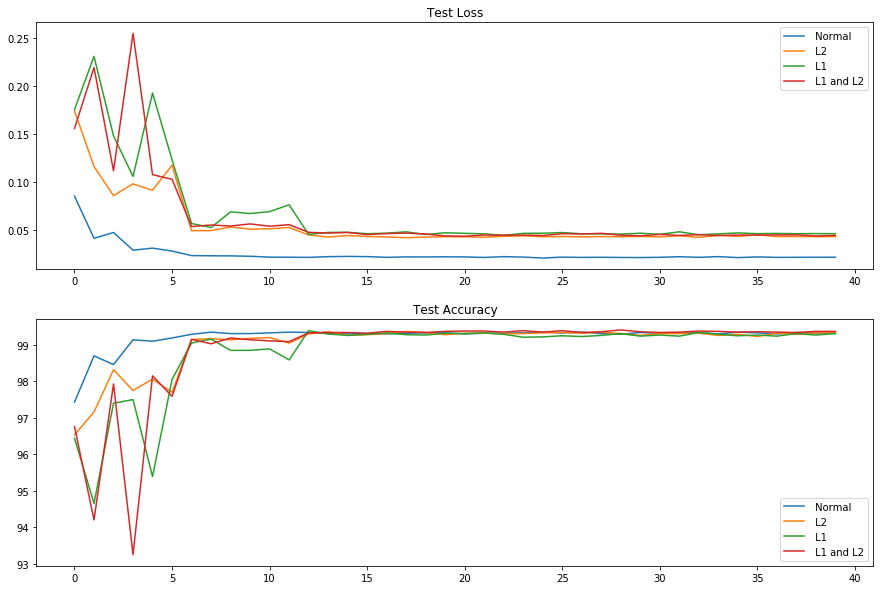

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, (axs1,axs2) = plt.subplots(2, 1,figsize=(15,10))

axs1.plot(tst_ls1, label = " Normal")
axs1.plot(tst_ls2, label = " L2")
axs1.plot(tst_ls3, label = " L1")
axs1.plot(tst_ls4, label = " L1 and L2")

axs1.set_title("Test Loss")

axs2.plot(tst_ac1, label = " Normal")
axs2.plot(tst_ac2, label = " L2")
axs2.plot(tst_ac3, label = " L1")
axs2.plot(tst_ac4, label = " L1 and L2")

axs2.set_title("Test Accuracy")
axs1.legend()
axs2.legend()
plt.show()


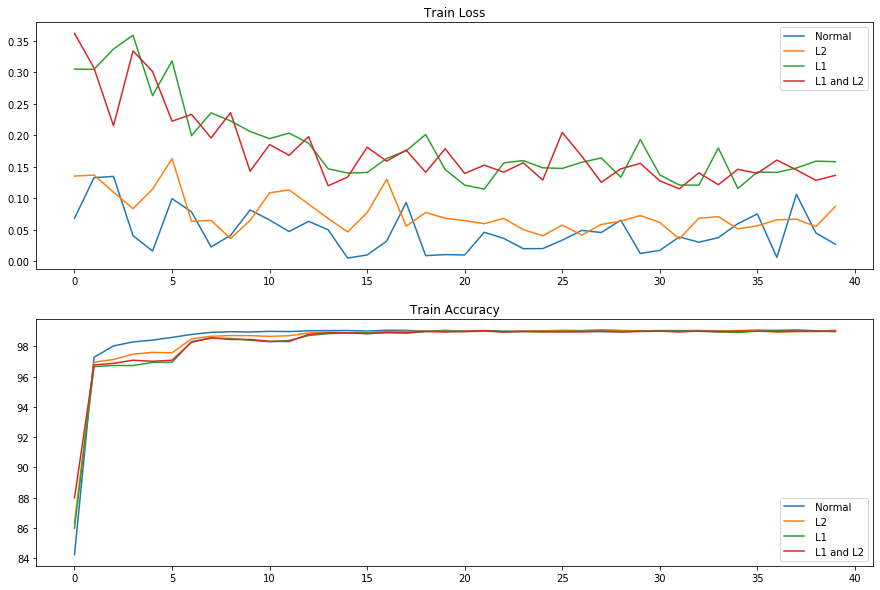

In [11]:
fig1, (axs3,axs4) = plt.subplots(2, 1,figsize=(15,10))

axs3.plot(trn_ls1, label = " Normal")
axs3.plot(trn_ls2, label = " L2")
axs3.plot(trn_ls3, label = " L1")
axs3.plot(trn_ls4, label = " L1 and L2")

axs3.set_title("Train Loss")

axs4.plot(trn_ac1, label = " Normal")
axs4.plot(trn_ac2, label = " L2")
axs4.plot(trn_ac3, label = " L1")
axs4.plot(trn_ac4, label = " L1 and L2")

axs4.set_title("Train Accuracy")
axs3.legend()
axs4.legend()
plt.show()
